# Regularization and Gradient Descent Exercises
![UnderOverFit.png](Assets/UnderOverFit.png)


# Learning Objectives

- Explain cost functions, regularization, feature selection, and hyper-parameters
- Summarize complex statistical optimization algorithms like gradient descent and its application to linear regression
- Apply Intel® Extension for Scikit-learn* to leverage underlying compute capabilities of hardware

# scikit-learn* 

Frameworks provide structure that Data Scientists use to build code. Frameworks are more than just libraries, because in addition to callable code, frameworks influence how code is written. 

A main virtue of using an optimized framework is that code runs faster. Code that runs faster is just generally more convenient but when we begin looking at applied data science and AI models, we can see more material benefits. Here you will see how optimization, particularly hyperparameter optimization can benefit more than just speed. 

These exercises will demonstrate how to apply **the Intel® Extension for Scikit-learn*,** a seamless way to speed up your Scikit-learn application. The acceleration is achieved through the use of the Intel® oneAPI Data Analytics Library (oneDAL). Patching is the term used to extend scikit-learn with Intel optimizations and makes it a well-suited machine learning framework for dealing with real-life problems. 

To get optimized versions of many Scikit-learn algorithms using a patch() approach consisting of adding these lines of code after importing sklearn: 

- **from sklearnex import patch_sklearn**
- **patch_sklearn()**

## This exercise relies on installation of  Intel® Extension for Scikit-learn*

If you have not already done so, follow the instructions from Week 1 for instructions


## Introduction

We will begin with a short tutorial on regression, polynomial features, and regularization based on a very simple, sparse data set that contains a column of `x` data and associated `y` noisy data. The data file is called `X_Y_Sinusoid_Data.csv`. 

In [1]:
from __future__ import print_function
import os
data_path = ['data/data2.csv']

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler

# from sklearnex import patch_sklearn
# patch_sklearn()

## Question 1

* Import the data. 

* Also generate approximately 100 equally spaced x data points over the range of 0 to 1. Using these points, calculate the y-data which represents the "ground truth" (the real function) from the equation: $y = sin(2\pi x)$

* Plot the sparse data (`x` vs `y`) and the calculated ("real") data.


In [7]:
import pandas as pd
import numpy as np

filepath = os.sep.join(data_path)
data = pd.read_csv(filepath)
data = data.drop('Unnamed: 0', axis=1)

# X_real = np.linspace(0, 1.0, 100)
# Y_real = np.sin(2 * np.pi * X_real)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [9]:
# Select the object (string) columns
mask = data.dtypes == object
categorical_cols = data.columns[mask]

In [10]:
# Determine how many extra columns would be created
num_ohc_cols = (data[categorical_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))


# No need to encode if there is only one value
small_num_ohc_cols = num_ohc_cols.loc[num_ohc_cols>1]

# Number of one-hot columns is one less than the number of categories
small_num_ohc_cols -= 1

# This is 215 columns, assuming the original ones are dropped. 
# This is quite a few extra columns!
small_num_ohc_cols.sum()

0.0

In [11]:
# Copy of the data
data_ohc = data.copy()

# The encoders
le = LabelEncoder()
ohc = OneHotEncoder()

for col in num_ohc_cols.index:
    
    # Integer encode the string categories
    dat = le.fit_transform(data_ohc[col]).astype(int)
    
    # Remove the original column from the dataframe
    data_ohc = data_ohc.drop(col, axis=1)

    # One hot encode the data--this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1,1))

    # Create unique column names
    n_cols = new_dat.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]

    # Create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(), 
                          index=data_ohc.index, 
                          columns=col_names)

    # Append the new data to the dataframe
    data_ohc = pd.concat([data_ohc, new_df], axis=1)

print(data_ohc)


         Duration  Distance      PLong       PLatd      DLong       DLatd  \
0               3        50  37.544666  126.888359  37.544666  126.888359   
1              24      7670  37.506199  127.003944  37.551250  127.035103   
2               8      1390  37.544590  127.057083  37.537014  127.061096   
3               8      1820  37.571102  127.023560  37.561447  127.034920   
4               4       850  37.573242  127.015907  37.565849  127.016403   
...           ...       ...        ...         ...        ...         ...   
9601134        67      6930  37.562607  127.051308  37.562607  127.051308   
9601135        58      8320  37.511982  127.085052  37.476028  127.105942   
9601136       118      2730  37.506199  127.003944  37.514870  127.015282   
9601137        90     17170  37.489750  126.927467  37.565903  126.901184   
9601138       116      1410  37.585655  127.075050  37.585655  127.075050   

         Haversine  Pmonth  Pday  Phour  ...  Dmin  DDweek  Temp  Precip  \

In [ ]:
# y_col = 'age'

# # Split the data that is not one-hot encoded
# feature_cols = [x for x in data.columns if x != y_col]
# X_data = data[feature_cols]
# y_data = data[y_col]

# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
#                                                     test_size=0.3, random_state=42)
# # Split the data that is one-hot encoded
# feature_cols = [x for x in data_ohc.columns if x != y_col]
# X_data_ohc = data_ohc[feature_cols]
# y_data_ohc = data_ohc[y_col]

# X_train_ohc, X_test_ohc, y_train_ohc, y_test_ohc = train_test_split(X_data_ohc, y_data_ohc, 
#                                                     test_size=0.3, random_state=42)

## Question 2


* Using the `PolynomialFeatures` class from Scikit-learn's preprocessing library, create 20th order polynomial features.
* Fit this data using linear regression. 
* Plot the resulting predicted value compared to the calculated data.

Note that `PolynomialFeatures` requires either a dataframe (with one column, not a Series) or a 2D array of dimension (`X`, 1), where `X` is the length.

In [12]:
print(data.shape[1])

# Remove the string columns from the dataframe
data = data.drop(num_ohc_cols.index, axis=1)

print(data.shape[1])

25
25


In [13]:
y_col = 'Duration'

# Split the data that is not one-hot encoded
feature_cols = [x for x in data.columns if x != y_col]
X_data = data[feature_cols]
y_data = data[y_col]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.3, random_state=42)
# Split the data that is one-hot encoded
feature_cols = [x for x in data_ohc.columns if x != y_col]
X_data_ohc = data_ohc[feature_cols]
y_data_ohc = data_ohc[y_col]

X_train_ohc, X_test_ohc, y_train_ohc, y_test_ohc = train_test_split(X_data_ohc, y_data_ohc, 
                                                    test_size=0.3, random_state=42)

In [14]:
LR = LinearRegression()

# Storage for error values
error_df = list()

# Data that have not been one-hot encoded
LR = LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

error_df.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred),
                           'test' : mean_squared_error(y_test,  y_test_pred)},
                           name='no enc'))

# Data that have been one-hot encoded
LR = LR.fit(X_train_ohc, y_train_ohc)
y_train_ohc_pred = LR.predict(X_train_ohc)
y_test_ohc_pred = LR.predict(X_test_ohc)

error_df.append(pd.Series({'train': mean_squared_error(y_train_ohc, y_train_ohc_pred),
                           'test' : mean_squared_error(y_test_ohc,  y_test_ohc_pred)},
                          name='one-hot enc'))

# Assemble the results
error_df = pd.concat(error_df, axis=1)
error_df

,no enc,one-hot enc
train,271.044726,271.044726
test,271.161132,271.161132


In [17]:
import time

scalers = {'standard': StandardScaler(),
           'minmax': MinMaxScaler(),
           'maxabs': MaxAbsScaler()}

training_test_sets = {
    'not_encoded': (X_train, y_train, X_test, y_test),
    'one_hot_encoded': (X_train_ohc, y_train_ohc, X_test_ohc, y_test_ohc)}


# Get the list of float columns, and the float data
# so that we don't scale something we already scaled. 
# We're supposed to scale the original data each time
mask = X_train.dtypes == float
float_columns = X_train.columns[mask]

# initialize model
LR = LinearRegression()

# iterate over all possible combinations and get the errors
errors = {}
for encoding_label, (_X_train, _y_train, _X_test, _y_test) in training_test_sets.items():
    for scaler_label, scaler in scalers.items():
        trainingset = _X_train.copy()  # copy because we dont want to scale this more than once.
        testset = _X_test.copy()
        trainingset[float_columns] = scaler.fit_transform(trainingset[float_columns])
        testset[float_columns] = scaler.transform(testset[float_columns])


        startTime = time.time()
        LR.fit(trainingset, _y_train)
        endTime = time.time()

        predictions = LR.predict(testset)
        key = encoding_label + ' - ' + scaler_label + 'scaling'
        errors[key] = mean_squared_error(_y_test, predictions)

        print(f"{key} / {endTime - startTime:.5f} sec")

errors = pd.Series(errors)
print(errors.to_string())
print('-' * 80)
for key, error_val in errors.items():
    print(key, error_val)

not_encoded - standardscaling / 5.10354 sec
not_encoded - minmaxscaling / 3.92917 sec
not_encoded - maxabsscaling / 3.61663 sec
one_hot_encoded - standardscaling / 3.54648 sec
one_hot_encoded - minmaxscaling / 3.52376 sec
one_hot_encoded - maxabsscaling / 3.63487 sec
not_encoded - standardscaling        271.161132
not_encoded - minmaxscaling          271.161132
not_encoded - maxabsscaling          271.161132
one_hot_encoded - standardscaling    271.161132
one_hot_encoded - minmaxscaling      271.161132
one_hot_encoded - maxabsscaling      271.161132
--------------------------------------------------------------------------------
not_encoded - standardscaling 271.16113213760775
not_encoded - minmaxscaling 271.1611321376078
not_encoded - maxabsscaling 271.1611321376078
one_hot_encoded - standardscaling 271.16113213760775
one_hot_encoded - minmaxscaling 271.1611321376078
one_hot_encoded - maxabsscaling 271.1611321376078


## Question 3

* Perform the regression on using the data with polynomial features using ridge regression ($\alpha$=0.001) and lasso regression ($\alpha$=0.0001). 
* Plot the results, as was done in Question 1. 
* Also plot the magnitude of the coefficients obtained from these regressions, and compare them to those obtained from linear regression in the previous question. The linear regression coefficients will likely need a separate plot (or their own y-axis) due to their large magnitude. 

What does the comparatively large magnitude of the data tell you about the role of regularization?

InvalidIndexError: (slice(None, None, None), None)

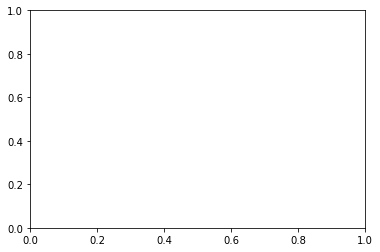

In [18]:
# Mute the sklearn warning about regularization
import warnings
warnings.filterwarnings('ignore', module='sklearn')

# The ridge regression model
rr = Ridge(alpha=0.001)
rr = rr.fit(X_data, y_data)
Y_pred_rr = rr.predict(X_data)

# The lasso regression model
lassor = Lasso(alpha=0.0001)

lassor = lassor.fit(X_data, y_data)
Y_pred_lr = lassor.predict(X_data)

# The plot of the predicted values
plt.plot(X_data, y_data, marker='o', ls='', label='data')
# plt.plot(X_real, Y_real, ls='--', label='real function')
# plt.plot(X_data, Y_pred, label='linear regression', marker='^', alpha=.5)
# plt.plot(X_data, Y_pred_rr, label='ridge regression', marker='^', alpha=.5)
# plt.plot(X_data, Y_pred_lr, label='lasso regression', marker='^', alpha=.5)

plt.legend()

ax = plt.gca()
ax.set(xlabel='x data', ylabel='y data')

In [20]:
# Mute the sklearn warning about regularization
import warnings
warnings.filterwarnings('ignore', module='sklearn')

# The ridge regression model
# rr = Ridge(alpha=0.001)
# rr = rr.fit(X_data_ohc, y_data)
# Y_pred_rr = rr.predict(X_data)

# The lasso regression model
lassor = Lasso(alpha=0.0001)
lassor = lassor.fit(X_data_ohc, y_data)
Y_pred_lr = lassor.predict(X_data_ohc)

# The plot of the predicted values
# plt.plot(X_data_ohc, y_data, marker='o', ls='', label='data')
# plt.plot(X_real, Y_real, ls='--', label='real function')
# plt.plot(X_data, Y_pred, label='linear regression', marker='^', alpha=.5)
# plt.plot(X_data, Y_pred_rr, label='ridge regression', marker='^', alpha=.5)
# plt.plot(X_data, Y_pred_lr, label='lasso regression', marker='^', alpha=.5)

# plt.legend()

# ax = plt.gca()
# ax.set(xlabel='x data', ylabel='y data');

In [21]:
# let's look at the absolute value of coefficients for each model

coefficients = pd.DataFrame()
coefficients['linear regression'] = LR.coef_.ravel()
# coefficients['ridge regression'] = rr.coef_.ravel()
coefficients['lasso regression'] = lassor.coef_.ravel()
coefficients = coefficients.applymap(abs)

coefficients.describe()  # Huge difference in scale between non-regularized vs regularized regression

,linear regression,lasso regression
count,24.000000,24.000000
mean,60.552186,0.891923
std,160.873819,1.485289
min,0.002730,0.001473
25%,0.087723,0.020676
50%,3.613060,0.167465
75%,6.880982,0.811934
max,712.119704,5.103515


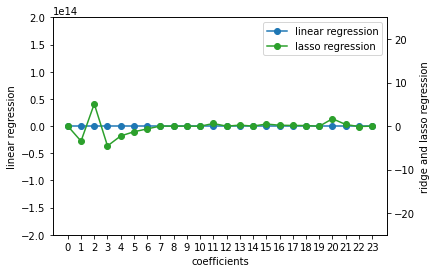

In [22]:
colors = sns.color_palette()

# Setup the dual y-axes
ax1 = plt.axes()
ax2 = ax1.twinx()

# Plot the linear regression data
ax1.plot(LR.coef_.ravel(), 
         color=colors[0], marker='o', label='linear regression')

# Plot the regularization data sets
# ax2.plot(rr.coef_.ravel(), 
#          color=colors[1], marker='o', label='ridge regression')

ax2.plot(lassor.coef_.ravel(), 
         color=colors[2], marker='o', label='lasso regression')

# Customize axes scales
ax1.set_ylim(-2e14, 2e14)
ax2.set_ylim(-25, 25)

# Combine the legends
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2)

ax1.set(xlabel='coefficients',ylabel='linear regression')
ax2.set(ylabel='ridge and lasso regression')

ax1.set_xticks(range(len(LR.coef_)));

## Question 4

For the remaining questions, we will be working with the [data set](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) from last lesson, which is based on housing prices in Ames, Iowa. There are an extensive number of features--see the exercises from week three for a discussion of these features.

To begin:

* Import the data with Pandas, remove any null values, and one hot encode categoricals. Either Scikit-learn's feature encoders or Pandas `get_dummies` method can be used.
* Split the data into train and test sets. 
* Log transform skewed features. 
* Scaling can be attempted, although it can be interesting to see how well regularization works without scaling features.

In [ ]:
filepath = os.sep.join(data_path + ['Ames_Housing_Sales.csv'])
data = pd.read_csv(filepath, sep=',')

Create a list of categorial data and one-hot encode. Pandas one-hot encoder (`get_dummies`) works well with data that is defined as a categorical.

In [ ]:
# Get a Pd.Series consisting of all the string categoricals
one_hot_encode_cols = data.dtypes[data.dtypes == object]  # filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields

# Here we see another way of one-hot-encoding:
# Encode these columns as categoricals so one hot encoding works on split data (if desired)
for col in one_hot_encode_cols:
    data[col] = pd.Categorical(data[col])

# Do the one hot encoding
data = pd.get_dummies(data, columns=one_hot_encode_cols)

Next, split the data in train and test data sets.

In [ ]:
train, test = train_test_split(data, test_size=0.3, random_state=42)

There are a number of columns that have skewed features--a log transformation can be applied to them. Note that this includes the `SalePrice`, our predictor. However, let's keep that one as is.

In [ ]:
# Create a list of float colums to check for skewing
mask = data.dtypes == float
float_cols = data.columns[mask]

In [ ]:
skew_limit = 0.75
skew_vals = train[float_cols].skew()

skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(skew_limit)))

skew_cols

Transform all the columns where the skew is greater than 0.75, excluding "SalePrice".

In [ ]:
# OPTIONAL: Let's look at what happens to one of these features, when we apply np.log1p visually.

field = "BsmtFinSF1"
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))
train[field].hist(ax=ax_before)
train[field].apply(np.log1p).hist(ax=ax_after)
ax_before.set(title='before np.log1p', ylabel='frequency', xlabel='value')
ax_after.set(title='after np.log1p', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));
# a little bit better

In [ ]:
# Mute the setting wtih a copy warnings
pd.options.mode.chained_assignment = None

for col in skew_cols.index.tolist():
    if col == "SalePrice":
        continue
    train[col] = np.log1p(train[col])
    test[col]  = test[col].apply(np.log1p)  # same thing

Separate features from predictor.

In [ ]:
feature_cols = [x for x in train.columns if x != 'SalePrice']
X_train = train[feature_cols].to_numpy()
y_train = train['SalePrice'].to_numpy()

X_test  = test[feature_cols].to_numpy()
y_test  = test['SalePrice'].to_numpy()

## Question 5

* Write a function **`rmse`** that takes in truth and prediction values and returns the root-mean-squared error. Use sklearn's `mean_squared_error`.  


In [23]:
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

* Fit a basic linear regression model
* print the root-mean-squared error for this model
* plot the predicted vs actual sale price based on the model.  

In [24]:
linearRegression = LinearRegression().fit(X_train_ohc, y_train_ohc)

linearRegression_rmse = rmse(y_train_ohc, linearRegression.predict(X_train_ohc))

print(linearRegression_rmse)

16.463436019534054


In [ ]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(y_train_ohc, linearRegression.predict(X_train_ohc), 
         marker='o', ls='', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Duration', 
       ylabel='Predicted Duration', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results');

## Question 6

Ridge regression uses L2 normalization to reduce the magnitude of the coefficients. This can be helpful in situations where there is high variance. The regularization functions in Scikit-learn each contain versions that have cross-validation built in.

* Fit a regular (non-cross validated) Ridge model to a range of $\alpha$ values and plot the RMSE using the cross validated error function you created above.
* Use $$[0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]$$ as the range of alphas.
* Then repeat the fitting of the Ridge models using the range of $\alpha$ values from the prior section. Compare the results.

Now for the `RidgeCV` method. It's not possible to get the alpha values for the models that weren't selected, unfortunately. The resulting error values and $\alpha$ values are very similar to those obtained above.

In [ ]:
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

# ridgeCV = RidgeCV(alphas=alphas, 
#                   cv=4).fit(X_train, y_train)

# ridgeCV_rmse = rmse(y_test, ridgeCV.predict(X_test))

# print(ridgeCV.alpha_, ridgeCV_rmse)

## Question 7


Much like the `RidgeCV` function, there is also a `LassoCV` function that uses an L1 regularization function and cross-validation. L1 regularization will selectively shrink some coefficients, effectively performing feature elimination.

The `LassoCV` function does not allow the scoring function to be set. However, the custom error function (`rmse`) created above can be used to evaluate the error on the final model.

Similarly, there is also an elastic net function with cross validation, `ElasticNetCV`, which is a combination of L2 and L1 regularization.

* Fit a Lasso model using cross validation and determine the optimum value for $\alpha$ and the RMSE using the function created above. Note that the magnitude of $\alpha$ may be different from the Ridge model.
* Repeat this with the Elastic net model.
* Compare the results via table and/or plot.

Use the following alphas:  
`[1e-5, 5e-5, 0.0001, 0.0005]`

In [ ]:
import time
alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])

# scaler = MinMaxScaler()
scaler = StandardScaler()

startTime = time.time()
X_train_scaled = scaler.fit_transform(X_train_ohc)
X_test_scaled = scaler.transform(X_test_ohc)

lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=3).fit(X_train_scaled, y_train)
endTime = time.time()
print(f"{endTime - startTime:.5f} sec")

lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test_scaled))

print(lassoCV.alpha_, lassoCV_rmse)  # Lasso is slower

We can determine how many of these features remain non-zero.

In [ ]:
print('Of {} coefficients, {} are non-zero with Lasso.'.format(len(lassoCV.coef_), 
                                                               len(lassoCV.coef_.nonzero()[0])))

Now try the elastic net, with the same alphas as in Lasso, and l1_ratios between 0.1 and 0.9

In [ ]:
l1_ratios = np.linspace(0.1, 0.9, 9)

elasticNetCV = ElasticNetCV(alphas=alphas2, 
                            l1_ratio=l1_ratios,
                            max_iter=1e4).fit(X_train, y_train)
elasticNetCV_rmse = rmse(y_test, elasticNetCV.predict(X_test))

print(elasticNetCV.alpha_, elasticNetCV.l1_ratio_, elasticNetCV_rmse)

Comparing the RMSE calculation from all models is easiest in a table.

In [ ]:
# scaler = MinMaxScaler()


rmse_vals = [linearRegression_rmse, lassoCV_rmse]

labels = ['Linear','Lasso']

rmse_df = pd.Series(rmse_vals, index=labels).to_frame()
rmse_df.rename(columns={0: 'RMSE'}, inplace=1)
rmse_df

We can also make a plot of actual vs predicted housing prices as before.

In [ ]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

labels = ['Lasso']

models = [lassoCV]

for mod, lab in zip(models, labels):
    ax.plot(y_test, mod.predict(X_test), 
             marker='o', ls='', ms=3.0, label=lab)


leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       title='Linear Regression Results');

## Question 8

Let's explore Stochastic gradient descent in this exercise.  
Recall that Linear models in general are sensitive to scaling.
However, SGD is *very* sensitive to scaling.  
Moreover, a high value of learning rate can cause the algorithm to diverge, whereas a too low value may take too long to converge.

* Fit a stochastic gradient descent model without a regularization penalty (the relevant parameter is `penalty`).
* Now fit stochastic gradient descent models with each of the three penalties (L2, L1, Elastic Net) using the parameter values determined by cross validation above. 
* Do not scale the data before fitting the model.  
* Compare the results to those obtained without using stochastic gradient descent.

In [ ]:
# Import SGDRegressor and prepare the parameters
model_parameters_dict = {
    'Linear': {'penalty': 'none'},
    'Lasso': {'penalty': 'l2',
           'alpha': lassoCV.alpha_},
    # 'Lasso': {'penalty': 'l2'},
    # 'Ridge': {'penalty': 'l1',
    #        'alpha': ridgeCV_rmse},
    # 'ElasticNet': {'penalty': 'elasticnet', 
    #                'alpha': elasticNetCV.alpha_,
    #                'l1_ratio': elasticNetCV.l1_ratio_}
}

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train_ohc, y_train_ohc)
    new_rmses[modellabel] = rmse(y_test_ohc, SGD.predict(X_test_ohc))

rmse_df['RMSE-SGD'] = pd.Series(new_rmses)
rmse_df

Notice how high the error values are! The algorithm is diverging. This can be due to scaling and/or learning rate being too high. Let's adjust the learning rate and see what happens.

* Pass in `eta0=1e-7` when creating the instance of `SGDClassifier`.
* Re-compute the errors for all the penalties and compare.

In [ ]:
# Import SGDRegressor and prepare the parameters
model_parameters_dict = {
    'Linear': {'penalty': 'none'},
    'Lasso': {'penalty': 'l2',
           'alpha': lassoCV.alpha_},
    # 'Ridge': {'penalty': 'l1',
    #        'alpha': ridgeCV_rmse},
    # 'ElasticNet': {'penalty': 'elasticnet', 
    #                'alpha': elasticNetCV.alpha_,
    #                'l1_ratio': elasticNetCV.l1_ratio_}
}

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(eta0=1e-7, **parameters)

    SGD.fit(X_train_ohc, y_train)

    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test_ohc))

rmse_df['RMSE-SGD-learningrate'] = pd.Series(new_rmses)
rmse_df

Now let's scale our training data and try again.

* Fit a `MinMaxScaler` to `X_train` create a variable `X_train_scaled`.
* Using the scaler, transform `X_test` and create a variable `X_test_scaled`. 
* Apply the same versions of SGD to them and compare the results. Don't pass in a eta0 this time.

In [ ]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler_start_time = time.time()
X_train_scaled = scaler.fit_transform(X_train_ohc)
scaler_end_time = time.time()

scaler_time = scaler_end_time - scaler_start_time
# print(scaler_time)

X_test_scaled = scaler.transform(X_test_ohc)

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)

    startTime = time.time()
    SGD.fit(X_train_scaled, y_train)
    endTime = time.time()
    print(f"{endTime - startTime + scaler_time:.5f} sec")

    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test_scaled))

rmse_df['RMSE-SGD-scaled'] = pd.Series(new_rmses)
rmse_df

In [ ]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ohc)
X_test_scaled = scaler.transform(X_test_ohc)

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train_scaled, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test_scaled))

rmse_df['RMSE-SGD-scaled'] = pd.Series(new_rmses)
rmse_df